In [1]:
import numpy as np
import scipy
import xarray as xr
import sys
from calendar import monthrange
import os
import matplotlib.pyplot as plt
import cmocean
from scipy import stats,signal


In [2]:
# Input from reading list of dates

dir_root = "/scratch/mgomez/STORM/idealSims/sst_32_skipd01_skipCoLES_ndg/"
dir_root = "/scratch/mgomez/STORM/idealSims/sst_31_skipd01_skipCoLES_ndg/"
# dir_root = "/projects/storm/mgomez/idealSims/sst_30_skipd01_skipCoLES_ndg/Results/"
# dir_root = "/scratch/mgomez/STORM/idealSims/sst_31md_skipd01_skipCoLES_ndg/"
dir_root = "/scratch/mgomez/Hurricane/idealized/sst_31_skipd01_skipCoLES_ndg/"

# Maximum height (to save memory)
iz_MMiin = 0 # 0 # 4
iz_MMaax = 15 #20 # 30 # 7
iz_max = iz_MMaax
iz_inBetween = 2 #2 # 2 # 1

# Make or not GIF
makeGIF = False

# Choose domain
domain = 'd02'
# File name root
fName = 'auxHist'
# File name contains this
fOther = ':00' # '06_04' # ':00' # '06_1' # ':00:'


# Find auxHist files for current domain within directory
entries = os.listdir(dir_root)
ofInterest = []
for ii in np.arange(len(entries)):
    # Check if file name matches
    if domain in entries[ii]:
        if fName in entries[ii]:
            if fOther in entries[ii]:
                ofInterest = np.append(ofInterest,ii)
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)

entries = ["auxHist24_d02_2000-01-06_01:00:10","auxHist24_d02_2000-01-06_01:10:10","auxHist24_d02_2000-01-06_01:19:10"]
ofInterest = [0,1,2]

# Extract and save data from each auxHist file (simulations WITHOUT turbines)
for i_f in np.arange(0,len(ofInterest)):
    # Open file
    ds = xr.open_dataset(dir_root+str(entries[ofInterest[i_f]]),decode_times=False)
    # Extract data
    u_temp = np.array(ds['U'])
    v_temp = np.array(ds['V'])
    w_temp = np.array(ds['W'])
    t_temp = np.array(ds['T']) + 300
    time_temp = np.array(ds['Times'])
    # De-stagger variables
    u_temp = 0.5*(u_temp[:,:,:,0:np.shape(u_temp)[3]-1]+u_temp[:,:,:,1:np.shape(u_temp)[3]])
    v_temp = 0.5*(v_temp[:,:,0:np.shape(v_temp)[2]-1,:]+v_temp[:,:,1:np.shape(v_temp)[2],:])
    w_temp = 0.5*(w_temp[:,0:np.shape(w_temp)[1]-1,:,:]+w_temp[:,1:np.shape(w_temp)[1],:,:])
    # Save variables
    if i_f == 0:
        # Only keep data within heights of interest
        u_temp = u_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        v_temp = v_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        w_temp = w_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        t_temp = t_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        # Create new variables
        u = np.zeros_like(u_temp) + u_temp
        v = np.zeros_like(v_temp) + v_temp
        w = np.zeros_like(w_temp) + w_temp
        theta = np.zeros_like(t_temp) + t_temp
        Time = []
        Time.append(time_temp)
        # Domain dimensions
        dx = ds.DX
        n_x = dx*np.arange(0,np.shape(u)[3])
        n_y = dx*np.arange(0,np.shape(u)[2])
    else: #if i_f>0:
        # Only keep data within heights of interest
        u_temp = u_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        v_temp = v_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        w_temp = w_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        t_temp = t_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        # Append data to saved variables
        u = np.append(u,u_temp,axis=0)
        v = np.append(v,v_temp,axis=0)
        w = np.append(w,w_temp,axis=0)
        theta = np.append(theta,t_temp,axis=0)
        Time.append(time_temp)
    # Free-up memory
    u_temp = 0.0
    v_temp = 0.0
    w_temp = 0.0
    t_temp = 0.0
    # Close file
    ds.close()
    print("Done with %i out of %i" % (i_f+1,len(ofInterest)))
print("Done extracting data")


# Height variable
if os.path.exists(dir_root +"wrfinput_"+domain): 
    ds = xr.open_dataset(dir_root +"wrfinput_"+domain,decode_times=False) 
elif os.path.exists(dir_root +"../wrfinput_"+domain): 
    ds = xr.open_dataset(dir_root +"../wrfinput_"+domain,decode_times=False) 
else:
    entries = os.listdir(dir_root)
    for ii in np.arange(len(entries)):
        # Check if file name matches
        if domain in entries[ii]:
            if 'wrfout' in entries[ii]:
                ofInterest = ii
    ds = xr.open_dataset(dir_root +entries[ofInterest],decode_times=False)
ph = ds['PH']
ph = np.array(ph[0,:,:,:])
phb = ds['PHB']
phb = np.array(phb[0,:,:,:])
height_stag = (ph+phb)/9.81
height_agl = 0.5*(height_stag[1:,:,:] + height_stag[0:-1,:,:])
# height_agl = height_agl[0:iz_max,:,:]
# Free-up memory
ph = 0.0
phb = 0.0
# height_stag = 0.0
ds.close()
ds = 0.0    

height_agl = np.mean(height_agl,axis=(1,2))
height_agl = height_agl[iz_MMiin:iz_max:iz_inBetween]

height_stag = np.mean(height_stag,axis=(1,2))
height_stag = height_stag[iz_MMiin:iz_max+iz_inBetween:iz_inBetween]


Done with 1 out of 3
Done with 2 out of 3
Done with 3 out of 3
Done extracting data


In [3]:
#%% Turbine specifications
D = 240 #126
z_hh = 150 #90


In [4]:
#%% Create time vector (after initialization) (ignore dates)
# Create large datetime64 array
ttime = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time)[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time)[0]):
    a = str(Time[i_t])
    ttime[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
    # ttime[i_t] = ttime[0] + np.timedelta64(5*60,dtype='datetime64[s]')*i_t
# Save portion of temp array that actually matters
ttime = ttime[0:np.shape(Time)[0]]

print(ttime)

['2000-01-06T01:00:10' '2000-01-06T01:10:10' '2000-01-06T01:19:10']


In [5]:
#%% Sort arrays by time
i_sort = np.argsort(ttime)
u = u[i_sort,:,:,:]
v = v[i_sort,:,:,:]
w = w[i_sort,:,:,:]
theta = theta[i_sort,:,:,:]
ttime = ttime[i_sort]

uv = (u**2 + v**2)**0.5


In [6]:
#%% Time since initialization
# t_init = np.datetime64('2000-01-05T00:00:23')
t_init = np.datetime64('2000-01-01T00:00:13')

time_sinceInit = ttime - t_init
time_sinceInit = time_sinceInit.astype('timedelta64[s]')

t_since = time_sinceInit.astype('float')/3600 # [hr]


In [7]:
#%% Find hub-height
i_hh = np.argmin(np.abs(height_agl - z_hh))


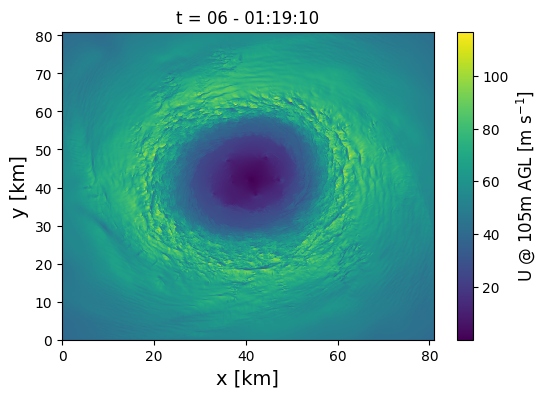

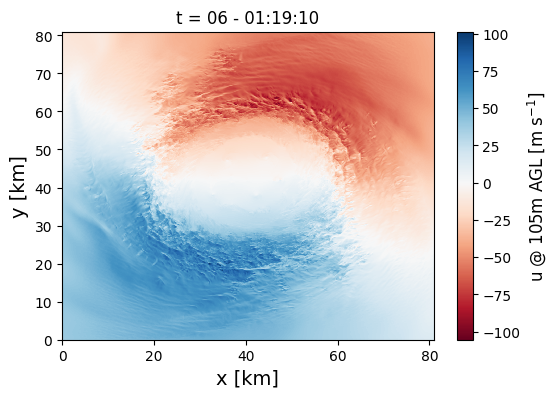

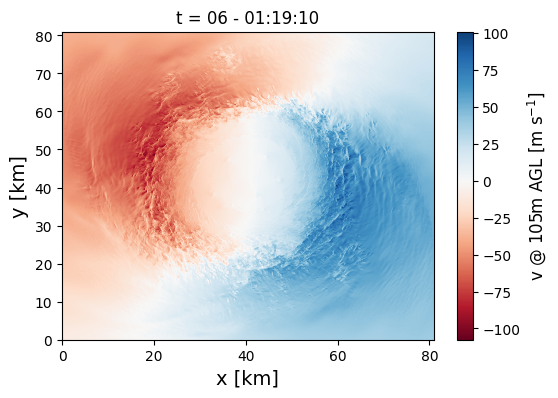

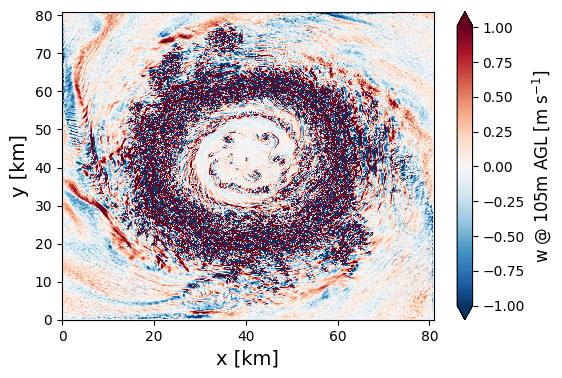

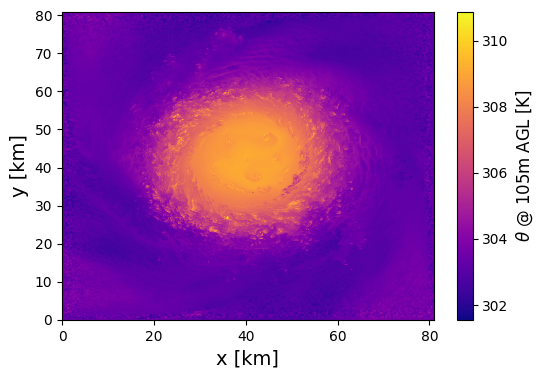

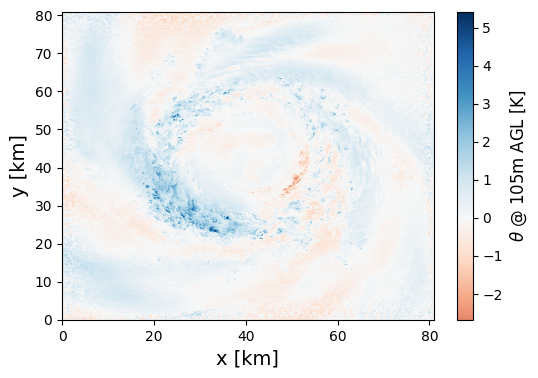

In [8]:
#%% Plot wind speed at one height
iz = 2 #np.min([9,len(height_agl)-1])#np.argmin(np.abs(height_agl - z_hh))
it = -1 #-7

# Horizontal wind speed
plt.figure(figsize=(6,4))
plt.title('t = '+str(ttime[it])[8:10]+' - '+str(ttime[it])[11:])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[it,iz,:,:])
cbar = plt.colorbar(im1)
cbar.set_label('U @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.scatter(n_x[4]/1000,n_y[4]/1000,color='r')
#if 'merged_d05.nc' in domain:
#    plt.scatter(n_x[locs_ts[:,0]]/1000,n_y[locs_ts[:,1]]/1000,s=5,color='red')
#plt.xlim(143*dx/1000,(143*dx + 403*4500)/1000)
#plt.ylim(143*dx/1000,(143*dx + 403*4500)/1000)
#plt.ylim(2000,4000)
#plt.xlim(2000,4000)
plt.show()
plt.close()


# Zonal wind speed
plt.figure(figsize=(6,4))
u[it,iz,0,0] = 0.5
u[it,iz,0,1] = -0.5
newCmap = cmocean.tools.crop(plt.cm.RdBu, np.min(u[it,iz,:,:]), np.max(u[it,iz,:,:]), 0)
plt.title('t = '+str(ttime[it])[8:10]+' - '+str(ttime[it])[11:])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,u[it,iz,:,:],cmap=newCmap)
cbar = plt.colorbar(im1)
cbar.set_label('u @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(2000,4000)
#plt.xlim(2000,4000)
plt.show()
plt.close()

# Meridional wind speed
plt.figure(figsize=(6,4))
v[it,iz,0,0] = 0.5
v[it,iz,0,1] = -0.5
newCmap = cmocean.tools.crop(plt.cm.RdBu, np.min(v[it,iz,:,:]), np.max(v[it,iz,:,:]), 0)
plt.title('t = '+str(ttime[it])[8:10]+' - '+str(ttime[it])[11:])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,v[it,iz,:,:],cmap=newCmap)
cbar = plt.colorbar(im1)
cbar.set_label('v @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(400000/1000,600000/1000)
#plt.xlim(400000/1000,600000/1000)
plt.show()
plt.close()


# Vertical wind speed
plt.figure(figsize=(6,4))
minn = -1.0#-0.5# np.min(w[it,iz,:,:])
maxx = 1.01#0.51 #np.max(w[it,iz,:,:])
newCmap = cmocean.tools.crop(plt.cm.RdBu_r, minn, maxx, 0)
im1 = plt.pcolormesh(n_x/1000,n_y/1000,w[it,iz,:,:],cmap=newCmap,vmin=minn,vmax=maxx)
cbar = plt.colorbar(im1,extend='both')
cbar.set_label('w @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(400000,600000)
#plt.xlim(400000,600000)
plt.show()
plt.close()


# Potential temperature
plt.figure(figsize=(6,4))
im1 = plt.pcolormesh(n_x/1000,n_y/1000,theta[it,iz,:,:],cmap=plt.cm.plasma)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\theta$ @ ' + str(int(height_agl[iz])) + 'm AGL [K]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(400000,600000)
#plt.xlim(400000,600000)
plt.show()
plt.close()

if len(ttime)>1:
    # Potential temperature
    plt.figure(figsize=(6,4))
    varr = theta[-1,iz,:,:] - theta[0,iz,:,:]
    minn = np.min(varr)
    maxx = np.max(varr)
    newCmap = cmocean.tools.crop(plt.cm.RdBu, minn, maxx, 0)
    im1 = plt.pcolormesh(n_x/1000,n_y/1000,varr,cmap=newCmap)
    cbar = plt.colorbar(im1)
    cbar.set_label(r'$\theta$ @ ' + str(int(height_agl[iz])) + 'm AGL [K]',fontsize=12)
    plt.ylabel('y [km]',fontsize=14)
    plt.xlabel('x [km]',fontsize=14)
    #plt.ylim(400000,600000)
    #plt.xlim(400000,600000)
    plt.show()
    plt.close()



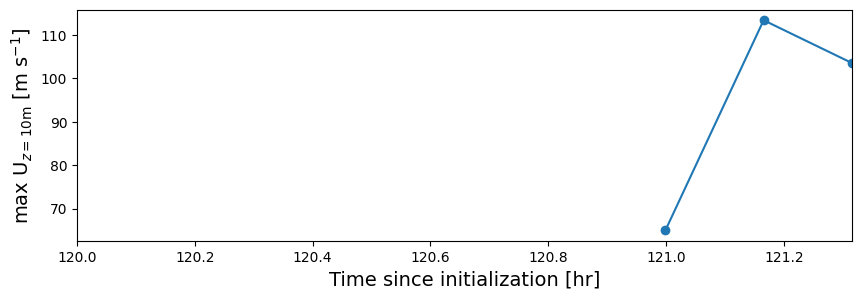

[120.99916667 121.16583333 121.31583333]
[ 65.00025177 113.40945435 103.53617096]


In [9]:
#%% Maximum velocity at the surface
temp_uv = np.zeros(np.shape(uv[:,0,:,:])) + uv[:,0,:,:]
temp_uv[:,0:10,:] = np.nan
temp_uv[:,-10:,:] = np.nan
temp_uv[:,:,0:10] = np.nan
temp_uv[:,:,-10:] = np.nan

max_uv_s = np.nanmax(temp_uv[:,:,:],axis=(1,2))

plt.figure(figsize=(10,3))
plt.plot(t_since[:],max_uv_s[:],'-o',zorder=0)
plt.xlabel('Time since initialization [hr]',fontsize=14)
plt.ylabel(r'max U$_{z=10 \rm m}$ [m s$^{-1}$]',fontsize=14)
plt.xlim(int(t_since[0]),t_since[-1])
# plt.xlim(80,t_since[-1])
# plt.ylim(58,70)
# plt.xlim(120,140)
# plt.legend()
plt.show()
plt.close()


# print(np.nanmean(temp_uv[-4]))
# print(ttime[-12])

print(t_since)
print(max_uv_s)



In [64]:
#%% Find center of hurricane based on minimum wind speed
center = np.zeros([len(ttime),2]) + np.nan # [x,y]

X_grid,Y_grid = np.meshgrid(n_x,n_y)
X_grid = X_grid.flatten()
Y_grid = Y_grid.flatten()

for iitt in np.arange(np.shape(uv)[0]):
    
    temp_uv = np.zeros(np.shape(uv[iitt,0,:,:])) + uv[iitt,0,:,:]
    temp_uv[0:10,:] = np.nan
    temp_uv[-10:,:] = np.nan
    temp_uv[:,0:10] = np.nan
    temp_uv[:,-10:] = np.nan
    uv_flat = temp_uv.flatten() #uv[-1,0,:,:].flatten()
    uv_flat[np.isnan(uv_flat)] = 0
    max_ws_ref = np.argmax(uv_flat)

    lim_low_x = np.mean(n_x) - 0.1*n_x[-1]
    lim_low_y = np.mean(n_x) - 0.1*n_x[-1]
    lim_high_x = np.mean(n_x) + 0.1*n_x[-1]
    lim_high_y = np.mean(n_x) + 0.1*n_x[-1]

    if 'd01' in domain:
        if iitt>0:
#             lim_low_x = center[iitt-1,0] - 0.1*n_x[-1]
#             lim_low_y = center[iitt-1,1] - 0.1*n_x[-1]
#             lim_high_x = center[iitt-1,0] + 0.1*n_x[-1]
#             lim_high_y = center[iitt-1,1] + 0.1*n_x[-1]
            lim_low_x = X_grid[max_ws_ref] - 0.1*n_x[-1]
            lim_low_y = Y_grid[max_ws_ref] - 0.1*n_x[-1]
            lim_high_x = X_grid[max_ws_ref] + 0.1*n_x[-1] 
            lim_high_y = Y_grid[max_ws_ref] + 0.1*n_x[-1]
        
    # Create small meshgrid
    small_x,small_y = np.meshgrid(n_x[(n_x<lim_high_x)&(n_x>lim_low_x)],n_y[(n_y<lim_high_y)&(n_y>lim_low_y)])
    flat_smallX = small_x.flatten()
    flat_smallY = small_y.flatten()

    # Crop array
    temp_uv_1 = uv[iitt,0,(n_y<lim_high_y)&(n_y>lim_low_y),:]
    temp_uv_2 = temp_uv_1[:,(n_x<lim_high_x)&(n_x>lim_low_x)]
    # Flatten array
    temp_uv_flat = temp_uv_2.flatten()
    # Find location of minimum
    if np.any(temp_uv_flat)==True:
        i_min = np.argmin(temp_uv_flat)
        # Save location of minimum
        center[iitt,0] = flat_smallX[i_min]
        center[iitt,1] = flat_smallY[i_min]
    else:
        # Save location of minimum
        center[iitt,0] = np.mean(n_x)
        center[iitt,1] = np.mean(n_y)
print(center/dx)

[[737. 763.]
 [736. 766.]
 [744. 757.]]


In [67]:
#%% Get geometrical center using velocity contours
slow_winds = [5,7,9]
slow_winds = [5,10,15]
geo_center2 = np.zeros([len(ttime),len(slow_winds),2])

dyn_center = center
for iitt in np.arange(len(ttime)):
    ## Limits on what to plot
    lim_low_x = dyn_center[iitt,0] - 0.3*np.mean(n_x)
    lim_low_y = dyn_center[iitt,1] - 0.3*np.mean(n_y)
    lim_high_x = dyn_center[iitt,0] + 0.3*np.mean(n_x)
    lim_high_y = dyn_center[iitt,1] + 0.3*np.mean(n_y)
    
    
    # Get contours for a set of slow wind speeds close to the hurricane center
    small_x = n_x[(n_x>lim_low_x) & (n_x<lim_high_x)]
    small_y = n_y[(n_y>lim_low_y) & (n_y<lim_high_y)]
    small_uv = uv[iitt,iz,(n_y>lim_low_y) & (n_y<lim_high_y),:]
    small_uv = small_uv[:,(n_x>lim_low_x) & (n_x<lim_high_x)]
    cs = plt.contour(small_x/1000,small_y/1000,small_uv, slow_winds)
    paths = cs.collections
    plt.close()
    
#    plt.figure()
#    plt.contourf(small_x/1000,small_y/1000,small_uv)
#    plt.contour(small_x/1000,small_y/1000,small_uv, slow_winds,cmap=plt.cm.binary)
#    plt.show()
    
    # Get vertices of contours for each wind speed
    for i_ws in np.arange(len(slow_winds)):
        allP = paths[i_ws].get_paths()
        # Find longest path
        longest = 0
        len_longest = 0
        if len(allP)>0:
            for i_p in np.arange(len(allP)):
                if len(allP[i_p]) > len_longest:
                    longest = i_p
                    len_longest = len(allP[i_p])
            path = allP[longest]
            verts = path.vertices
            x_contour = verts[:,0]
            y_contour = verts[:,1]
            geo_center2[iitt,i_ws,0] = np.mean(x_contour)*1000
            geo_center2[iitt,i_ws,1] = np.mean(y_contour)*1000
        

In [68]:
#%% Choose which method for finding the center
meth_cent = 'oth'
if meth_cent=='geo':
    temp_cent = np.zeros_like(geo_center2[:,1,:]) + geo_center2[:,2,:] + 0.0
else:
    temp_cent = np.zeros_like(center) + center + 0.0


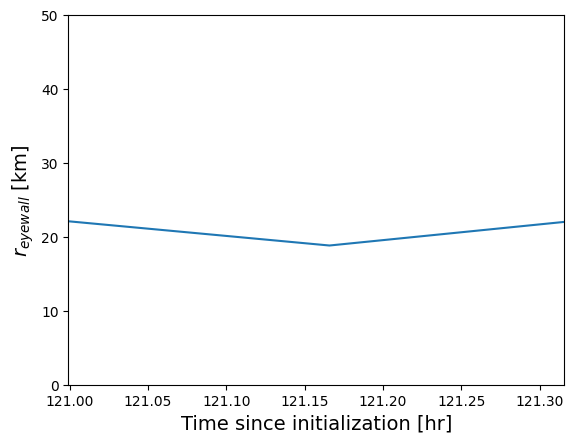

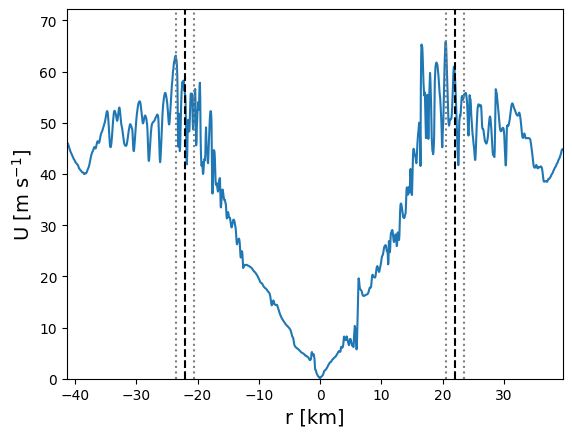

[22111.12848663 18833.34813309 22027.79508781]


In [69]:
#%% Find radius of eyewall in hurricane
r_eye = np.zeros(np.shape(ttime))
r1 = np.zeros(np.shape(ttime))
r2 = np.zeros(np.shape(ttime))

r_x = (n_x - temp_cent[-1,0])/1000


# Find radius of eyewall for each time
for ii in np.arange(0,len(ttime)):
    temp_uv = np.zeros(np.shape(uv[ii,0,:,:])) + uv[ii,0,:,:]
    temp_uv[0:10,:] = 0
    temp_uv[-10:,:] = 0
    temp_uv[:,0:10] = 0
    temp_uv[:,-10:] = 0
    
    i_r_max1 = np.argmax(temp_uv[int(temp_cent[ii,1]/dx),int(temp_cent[ii,0]/dx):])
    i_r_max2 = np.argmax(temp_uv[int(temp_cent[ii,1]/dx),0:int(temp_cent[ii,0]/dx)])
    r1[ii] = np.abs(n_x[int(temp_cent[ii,0]/dx):][i_r_max1] - temp_cent[ii,0])
    r2[ii] = np.abs(n_x[0:int(temp_cent[ii,0]/dx)][i_r_max2] - temp_cent[ii,0])
    r_eye[ii] = 0.5*(r1[ii] + r2[ii])

# Temporal evolution of hurricane eyewall
plt.figure()
plt.plot(t_since,r_eye/1000)
plt.xlabel('Time since initialization [hr]',fontsize=14)
plt.ylabel(r'$r_{eyewall}$ [km]',fontsize=14)
plt.xlim(t_since[0],t_since[-1])
plt.ylim(0,50)
plt.show()
plt.close() 

# Plot of wind speed
it = -1
plt.figure()
plt.plot((n_x-center[it,0])/1000,uv[it,0,int(temp_cent[it,1]/dx),:])
plt.plot(np.array([r_eye[it],r_eye[it]])/1000,[0,100],'--k')
plt.plot(np.array([-1*r_eye[it],-1*r_eye[it]])/1000,[0,100],'--k')

plt.plot(np.array([-1*r1[it],-1*r1[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')
plt.plot(np.array([-1*r2[it],-1*r2[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')

plt.plot(np.array([r1[it],r1[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')
plt.plot(np.array([r2[it],r2[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')

plt.xlim(np.min((n_x - center[it,0])/1000),np.max((n_x - center[it,0])/1000))
plt.xlim(np.max([-200,r_x[0]]),np.min([200,r_x[-1]]))
plt.ylim(0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5)
plt.xlabel('r [km]',fontsize=14)
plt.ylabel('U [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close()  

print(r_eye)


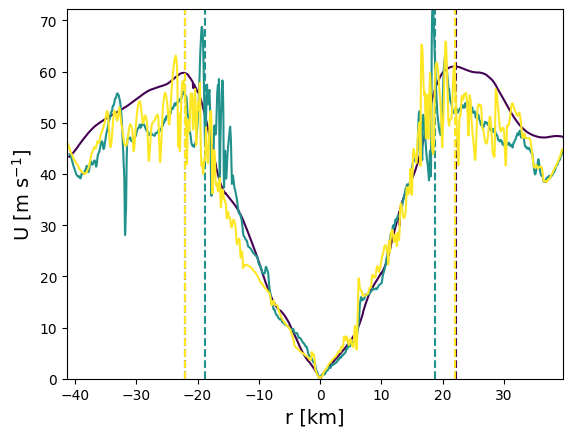

In [70]:
#%% Evolution of radius of maximum winds
cols = plt.cm.viridis(np.linspace(0,1,len(ttime)))
plt.figure()
for it in np.arange(len(ttime)):
    plt.plot((n_x-center[it,0])/1000,uv[it,0,int(temp_cent[it,1]/dx),:],color=cols[it])
    plt.plot(np.array([r_eye[it],r_eye[it]])/1000,[0,100],'--',color=cols[it])
    plt.plot(np.array([-1*r_eye[it],-1*r_eye[it]])/1000,[0,100],'--',color=cols[it])

plt.xlim(np.min((n_x - temp_cent[it,0])/1000),np.max((n_x - temp_cent[it,0])/1000))
plt.xlim(np.max([-350,r_x[0]]),np.min([350,r_x[-1]]))
plt.ylim(0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5)
plt.xlabel('r [km]',fontsize=14)
plt.ylabel('U [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close() 


In [71]:
#%% Crop all 3D fields to a shared reference frame that is centered on the center of the hurricane
# Maximum distance from center of the hurricane
max_dist_fromCent = 200000

# Find the maximum radial distance from the hurricane's center that is shared for all times
for it in np.arange(len(ttime)):
    # Distance from hurricane cetner to domain boundaries
    dd_x = np.min([center[it,0] - n_x[0],n_x[-1] - center[it,0]])
    dd_y = np.min([center[it,1] - n_y[0],n_y[-1] - center[it,1]])
    # Minimum distance to domain boundaries
    dd = np.min([dd_x,dd_y])
    if dd<max_dist_fromCent:
        max_dist_fromCent = dd
# Round down
temp = np.floor(max_dist_fromCent/1000)
max_dist_fromCent = temp*1000

# Initialize array
u_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
v_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
w_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
theta_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
uv_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan

for iitt in np.arange(len(ttime)):
    # Geometrical center
    geo_cent = [center[iitt,0],center[iitt,1]]
    ix_c = int(geo_cent[0]/dx)
    iy_c = int(geo_cent[1]/dx)
    # Save portion of hurricane
    if iitt==0:
        dim1 = np.shape(u_r[iitt,:,:,:])[-1]
        dim2 = np.shape(u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)])[-1]
    if dim1==dim2:
        u_r[iitt,:,:,:] = u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        v_r[iitt,:,:,:] = v[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        w_r[iitt,:,:,:] = w[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        theta_r[iitt,:,:,:] = theta[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        uv_r[iitt,:,:,:] = uv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
    else:
        u_r[iitt,:,:,:] = u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        v_r[iitt,:,:,:] = v[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        w_r[iitt,:,:,:] = w[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        theta_r[iitt,:,:,:] = theta[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        uv_r[iitt,:,:,:] = uv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
    
    
# Release memory
# u = 0.0
# v = 0.0
# w = 0.0
# uv = 0.0
# theta = 0.0

# # Temporal average of centered velocity fields
# mean_u_r = np.nanmean(u_r,axis=0)
# mean_v_r = np.nanmean(v_r,axis=0)
# mean_w_r = np.nanmean(w_r,axis=0)
# mean_theta_r = np.nanmean(theta_r,axis=0)
mean_uv_r = np.nanmean(uv_r,axis=0)

# New distance arrays
n_x_r = np.arange(np.shape(mean_uv_r)[2])*dx
n_y_r = np.arange(np.shape(mean_uv_r)[1])*dx
temp_gridx,temp_gridy = np.meshgrid(n_x_r,n_y_r)
temp_uv = mean_uv_r[0,:,:].flatten()
temp_gridx = temp_gridx.flatten()
temp_gridy = temp_gridy.flatten()
n_x_r = n_x_r - temp_gridx[np.argmin(temp_uv)]
n_y_r = n_y_r - temp_gridy[np.argmin(temp_uv)]

temp_uv = 0.0
temp_gridx = 0.0
temp_gridy = 0.0

In [72]:
#%% Crop 3D fields to make them centered in a rectangle (x-y)
min_x = np.min(np.abs(np.array([n_x_r[0],n_x_r[-1]])))
min_y = np.min(np.abs(np.array([n_y_r[0],n_y_r[-1]])))

u_r = u_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
u_r = u_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

v_r = v_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
v_r = v_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

w_r = w_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
w_r = w_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

theta_r = theta_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
theta_r = theta_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

uv_r = uv_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
uv_r = uv_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

n_x_r = n_x_r[(n_x_r>-1*min_x)&(n_x_r<min_x)]
n_y_r = n_y_r[(n_y_r>-1*min_y)&(n_y_r<min_y)]


In [73]:
#%% Calculate temporal average after spinup
t0 = 3#7 #np.argmin(np.abs(t_since - 34))
t1 = t0+1 #np.argmin(np.abs(t_since - 40))
# t0 = np.argmin(np.abs(t_since - 39))
# t1 = np.argmin(np.abs(t_since - 51))

# Temporal average of centered velocity fields
mean_u_r = np.nanmean(u_r[t0:t1,:,:,:],axis=0)
mean_v_r = np.nanmean(v_r[t0:t1,:,:,:],axis=0)
mean_w_r = np.nanmean(w_r[t0:t1,:,:,:],axis=0)
mean_theta_r = np.nanmean(theta_r[t0:t1,:,:,:],axis=0)
mean_uv_r = np.nanmean(uv_r[t0:t1,:,:,:],axis=0)

print(ttime[t0:t1])
# print(ttime[t1])

/home/mgomez/.conda/envs/python_msg/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/mgomez/.conda/envs/python_msg/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == "__main__":
/home/mgomez/.conda/envs/python_msg/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/mgomez/.conda/envs/python_msg/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/mgomez/.conda/envs/python_msg/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == "":


[]


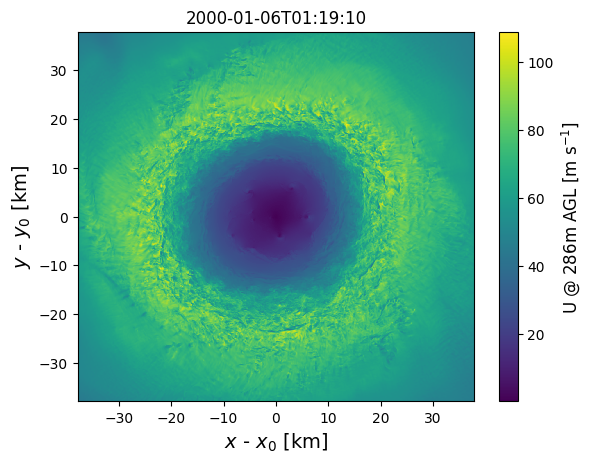

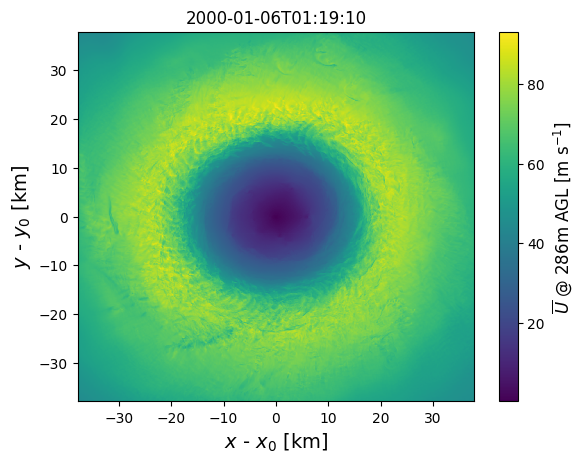

In [74]:
# Velocity contours at one height
iz = 5
it = -1 #len(ttime)-1

plt.figure()
plt.title(ttime[it])
im1 = plt.pcolormesh(n_x_r/1000,n_y_r/1000,uv_r[it,iz,:,:])
plt.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
plt.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
cbar = plt.colorbar(im1)
cbar.set_label(r'U @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close()  


plt.figure()
plt.title(ttime[it])
im1 = plt.pcolormesh(n_x_r/1000,n_y_r/1000,np.nanmean(uv_r[:,iz,:,:],axis=0))
plt.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
plt.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{U}$ @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close()  
